In [7]:
import xgi
import random
from hyperfunctions import *
import pandas as pd

In [1]:
## Top K nodes based on a centrality dictionary ##
def topK(cent, K=None, return_list=False):
    """
    Given a dictionary node-centrality score, return the top K ranking
    """

    if not K:
        K = len(cent)
    
    C = sorted(cent, key=cent.get, reverse=True)[:K]
    ranking = {key: cent[key] for key in C}
    
    if return_list:
        return C

    return ranking

In this notebook we will explore one of the random generators from XGI library. It is based on Erdös-Renyi graph generation method, as can be seen in the docs.

In [8]:
# Let's explore with a sample hypergraph
H_rand = xgi.generators.random.random_hypergraph(100, [0.5, 0.03, 0.003, 0.0003])

In [9]:
# Gonzalo's method that cleans the hypergraph
H_rand.remove_edges_from(H_rand.edges.singletons()) # Remove edges with a single node in them (there are ~5000)
H_rand.remove_nodes_from(H_rand.nodes.isolates())   # There are 6 nodes which only belonged to those singleton edges, we remove them as well.
# Relabel all nodes to start from zero to the current number of nodes
H_rand = xgi.convert_labels_to_integers(H_rand)
H_rand.cleanup(connected=False) #This basically does the same as the three above + checks for multiedges and removes them
len(H_rand.nodes), len(H_rand.edges), H_rand.edges.size.max()

(100, 41524, 5)

In [10]:
# We will create a Df to store the differents measurements
df_rand = pd.DataFrame()

In [13]:
# Check number of hyperedges of the different sizes
sizesr = {2:0, 3:0, 4:0, 5:0}
for edge in H_rand.edges.members():
    sizesr[len(edge)] += 1
sizesr

{2: 2472, 3: 4728, 4: 11821, 5: 22503}

Let's compute the different centralities measurements

In [15]:
cecr = xgi.clique_eigenvector_centrality(H_rand)
df_rand['CEC'] = list(cecr.values())

In [16]:
# Vamos con nuestros métodos
t2 = uniform_adjacency_combinatorial_tensor(H_rand, m = 2, math_notation = False)
centr2 = HEC_ours(t2, m=2, niter=100000, tol=1e-6, verbose=True)

if centr2[1]:
    df_rand['UPHEC2'] = centr2[0]

Finished in 2 iterations.


In [17]:
%%time
t3 = uniform_adjacency_combinatorial_tensor(H_rand, m = 3, math_notation = False)
centr3 = HEC_ours(t3, m=3, niter=100000, tol=1e-6, verbose=True)

centr3new = centr3[0][:-1]
centr3new = centr3new/sum(centr3new)
if centr3[1]:
    df_rand['UPHEC3'] = centr3new

Finished in 2 iterations.
CPU times: total: 30.4 s
Wall time: 31.5 s


In [18]:
%%time
t4 = uniform_adjacency_combinatorial_tensor(H_rand, m = 4, math_notation = False)
centr4 = HEC_ours(t4, m=4, niter=100000, tol=1e-6, verbose=True)

centr4new = centr4[0][:-1]
centr4new = centr4new/sum(centr4new)
if centr4[1]:
    df_rand['UPHEC4'] = centr4new

Finished in 4 iterations.
CPU times: total: 2min 54s
Wall time: 3min


In [19]:
%%time
t5 = uniform_adjacency_combinatorial_tensor(H_rand, m = 5, math_notation = False)
centr5 = HEC_ours(t5, m=5, niter=100000, tol=1e-6, verbose=True)

centr5new = centr5[0][:-1]
centr5new = centr5new/sum(centr5new)
if centr5[1]:
    df_rand['UPHEC5'] = centr5new

Finished in 4 iterations.
CPU times: total: 4min 3s
Wall time: 4min 6s


In [25]:
edgedict = H_rand.edges.members(dtype=dict)

In [26]:
rand = H_rand

In [27]:
rand2 = rand.copy()
for edge, members in edgedict.items():
    if len(members) != 2:
        rand2.remove_edge(edge)

rand2.remove_nodes_from(rand2.nodes - xgi.algorithms.largest_connected_component(rand2))

cent2unif = xgi.algorithms.h_eigenvector_centrality(rand2)

for missing_node in range(len(rand.nodes)):
    if missing_node not in cent2unif.keys():
        cent2unif[missing_node] = 0

df_rand["HEC-2unif"] = cent2unif

In [28]:
rand3 = rand.copy()
for edge, members in edgedict.items():
    if len(members) != 3:
        rand3.remove_edge(edge)

rand3.remove_nodes_from(rand3.nodes - xgi.algorithms.largest_connected_component(rand3))

cent3unif = xgi.algorithms.h_eigenvector_centrality(rand3)

for missing_node in range(len(rand.nodes)):
    if missing_node not in cent3unif.keys():
        cent3unif[missing_node] = 0

df_rand["HEC-3unif"] = cent3unif

In [29]:
rand4 = rand.copy()
for edge, members in edgedict.items():
    if len(members) != 4:
        rand4.remove_edge(edge)

rand4.remove_nodes_from(rand4.nodes - xgi.algorithms.largest_connected_component(rand4))

cent4unif = xgi.algorithms.h_eigenvector_centrality(rand4)

for missing_node in range(len(rand.nodes)):
    if missing_node not in cent4unif.keys():
        cent4unif[missing_node] = 0

df_rand["HEC-4unif"] = cent4unif

In [30]:
rand5 = rand.copy()
for edge, members in edgedict.items():
    if len(members) != 5:
        rand5.remove_edge(edge)

rand5.remove_nodes_from(rand5.nodes - xgi.algorithms.largest_connected_component(rand5))

cent5unif = xgi.algorithms.h_eigenvector_centrality(rand5)

for missing_node in range(len(rand.nodes)):
    if missing_node not in cent5unif.keys():
        cent5unif[missing_node] = 0

df_rand["HEC-5unif"] = cent5unif

In [31]:
df_dict_rand = df_rand.to_dict()

In [32]:
from collections import defaultdict
import scipy
KTtopK = defaultdict(list)

for key1, value1 in df_dict_rand.items():
    
    print("Comparing", key1, "against the rest.")
    
    for key2, value2 in df_dict_rand.items():
        
        if key1 == key2:
            continue
        
        for k in range(1, len(df_rand)):
                        
            topk1 = topK(value1, K=k)
            centrals2 = [value2[node] for node in topk1.keys()]
            
            KTtopK[key1 + " -> " + key2].append(scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic )

Comparing CEC against the rest.
Comparing UPHEC2 against the rest.
Comparing UPHEC3 against the rest.
Comparing UPHEC4 against the rest.
Comparing UPHEC5 against the rest.
Comparing HEC-2unif against the rest.
Comparing HEC-3unif against the rest.
Comparing HEC-4unif against the rest.
Comparing HEC-5unif against the rest.


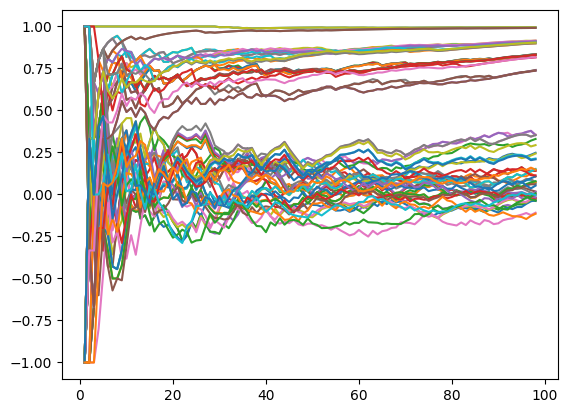

In [34]:
import matplotlib.pyplot as plt
for key, val in KTtopK.items():
    plt.plot(val, label=key)

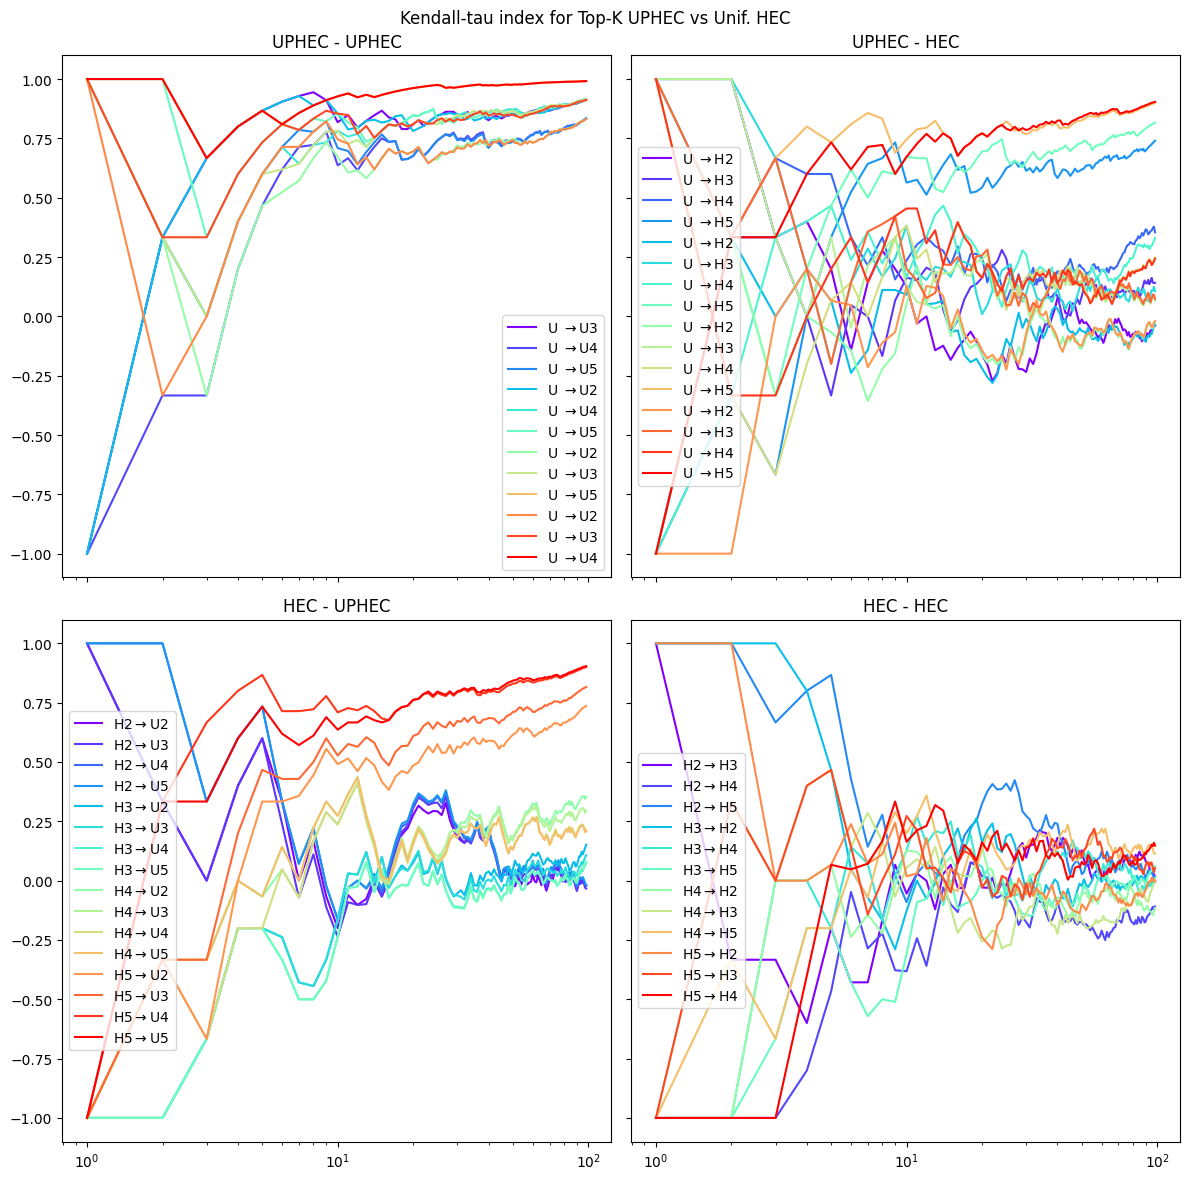

In [35]:
fig, ax = plt.subplots(2,2, figsize=(12,12), sharex=True, sharey=True)
# Colormap for the plots
cmap = plt.get_cmap('rainbow') #rainbow, hsv, viridis, cool
fig.suptitle("Kendall-tau index for Top-K UPHEC vs Unif. HEC")

colorUU = iter(cmap(np.linspace(0, 1, 4*3)))
colorUH = iter(cmap(np.linspace(0, 1, 4*4)))
colorHU = iter(cmap(np.linspace(0, 1, 4*4)))
colorHH = iter(cmap(np.linspace(0, 1, 4*3)))

for key, val in KTtopK.items():
    
    if "UP" in key[0:3] and "UP" in key[-8:]:
        
        ax[0,0].plot(val, label=f"U{key[6]}" + r"$\rightarrow$"+ f"U{key[-1]}", color=next(colorUU))
        ax[0,0].set_title("UPHEC - UPHEC")
    
    elif "UP" in key[0:3] and "unif" in key[-5:]:
        
        ax[0,1].plot(val, label=f"U{key[6]}" + r"$\rightarrow$"+ f"H{key[-5]}", color=next(colorUH))
        ax[0,1].set_title("UPHEC - HEC")
    
    elif "unif" in key[0:9] and "UP" in key[-8:]:
        
        ax[1,0].plot(val, label=f"H{key[4]}" + r"$\rightarrow$"+ f"U{key[-1]}", color=next(colorHU))
        ax[1,0].set_title("HEC - UPHEC")
    
    elif "unif" in key[0:9] and "unif" in key[-5:]:
        
        ax[1,1].plot(val, label=f"H{key[4]}" + r"$\rightarrow$"+ f"H{key[-5]}", color=next(colorHH))
        ax[1,1].set_title("HEC - HEC")
        

ax[0,0].set_xscale('log')
ax[0,1].set_xscale('log')
ax[1,0].set_xscale('log')
ax[1,1].set_xscale('log')

        
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

plt.tight_layout()

plt.show()

Now, let's explore some alternatives to take into account the increasing number of nodes as well as the probabilty variation

In [121]:
def uphec_compute(h, m):
    t = uniform_adjacency_combinatorial_tensor(h, m = m, math_notation = False)
    centr = HEC_ours(t, m=m, niter=100000, tol=1e-6, verbose=True)
    a_centr = centr[0]
    if m > 2:
        a_centr = a_centr[:-1]
        a_centr = a_centr/sum(a_centr)
    if centr[1]:
        return a_centr
    else:
        print("There have been a mistake for UPHEC method with m {}".format(m))

def benson_compute(h, m):
    edgedict = h.edges.members(dtype=dict)
    h_i = h.copy()
    for edge, members in edgedict.items():
        if len(members) != m:
            h_i.remove_edge(edge)
    try:
        h_iunif = xgi.algorithms.h_eigenvector_centrality(xgi.algorithms.largest_connected_hypergraph(h_i))
    except:
        return False
    for missing_node in range(len(h.nodes)):
        if missing_node not in h_iunif.keys():
            h_iunif[missing_node] = 0
    return h_iunif

In [137]:
nnodes = [20, 30, 40, 50]
probs_i = [0.1, 0.01, 0.001, 0.0001]
add_probs = [0.07, 0.02, 0.001, 0.0001]

In [123]:
seed = 123842

In [124]:
dict_exp = dict()
for i in nnodes:
    dict_exp[i] = dict()
    probs_aux = probs_i
    for j in range(40):
        dict_exp[i][tuple(probs_aux)] = dict()
        for m in range(2, 6):
            uni = False
            h_j = xgi.generators.random.random_hypergraph(i, probs_i, seed = seed)
            vuphec = uphec_compute(h_j, m)
            kt = scipy.stats.kendalltau(vuphec, list(bhec.values())).statistic
            dict_exp[i][tuple(probs_aux)][m] = kt
        probs_aux = [probs_aux[k] + add_probs[k] for k in range(4)]
    

Finished in 9 iterations.
Finished in 10 iterations.
Finished in 9 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in

Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 

Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 8 iterations.
Finished in 

KeyboardInterrupt: 

In [153]:
# No need to do this, is already store as dict_exp.json
dict_res = dict()
for n in [25, 50, 75, 100]:
    dict_res[n] = dict()
    for p in range(10):
        probs = np.array(probs_i) + p*np.array(add_probs)
        print(probs)
        dict_res[n][tuple(probs)] = dict()
        ls_cent = []
        h_j = xgi.generators.random.random_hypergraph(n, probs, seed = seed)
        for m in range(2, 6):
            vuphec = uphec_compute(h_j, m)
            ls_cent.append(vuphec)
        for l in range(len(ls_cent)):
            for s in range(len(ls_cent)):
                if l == s:
                    break
                kt = scipy.stats.kendalltau(ls_cent[l], ls_cent[s]).statistic
                dict_res[n][tuple(probs)]['UH{}vsUH{}'.format(l + 2, s + 2)] = kt

[0.1    0.01   0.001  0.0001]
Finished in 8 iterations.
Finished in 13 iterations.
Finished in 19 iterations.
Finished in 19 iterations.
[0.17   0.03   0.002  0.0002]
Finished in 5 iterations.
Finished in 6 iterations.


KeyboardInterrupt: 

In [155]:
f = open('dict_exp.json')

In [156]:
import json
dict_res = json.load(f)

In [158]:
dict_res = {int(k): v for k, v in dict_res.items()}

Let's plot for different numbers of nodes

In [160]:
import matplotlib.pyplot as plt

In [183]:
nodes = [25, 50, 75, 100]

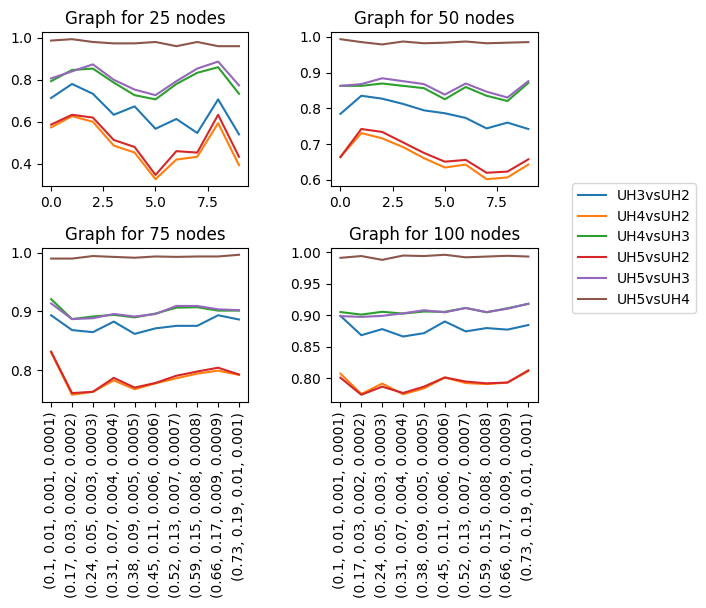

In [206]:
fig, ax = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace = 0.4)
s = 0
for i in range(2):
    for j in range(2):
        d_n = dict_res[nodes[s]]
        x = range(len(v))
        keys_as_tuples = [tuple([round(float(x.replace('(', '').replace(')', '').replace(' ', '')), 4) for x in i.split(',')]) for i in d_25.keys()]
        dict_y = dict()
        for k1, v1 in d_n.items():
            for k2, v2 in v1.items():
                if k2 not in dict_y:
                    dict_y[k2] = [v2]
                else:
                    dict_y[k2].append(v2)
        for kp, vp in dict_y.items():
            ax[i,j].plot(x, vp, label = kp)
        ax[i, j].set_title('Graph for {} nodes'.format(nodes[s]))
        if i == 1:
            ax[i, j].set_xticks(x, keys_as_tuples, rotation=90)
        s += 1
plt.legend(bbox_to_anchor = (1.8, 1), loc='center right')
plt.show()